In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy
import datetime

# для расчетов над tdb
from pycalphad import Database, equilibrium, variables as v, binplot

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import pytensor
import pytensor.tensor as pt
# import theano
# theano.config.exception_verbosity = 'high' # должно выдавать подробное описание ошибки, но не помогает

import aesara

import seaborn as sns

# пути к tdb
cc10_path = "tdbs\CoCr-18Cac_with_new_functions.tdb"

print(f"Running on PyMC v{pm.__version__}") # 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.1.2
Running on NumPy v1.22.1
Running on ArviZ v0.12.1


In [2]:
def from_xarray_to_pandas(xarray_data, phase_str):
    cr_tuple = xarray_data.X.sel(component = 'CR').data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data
    
    # print('- t_tuple', len(t_tuple))
    
    # переписать короче
    df_res = pd.DataFrame()
    df_res['T'] = ''
    df_res['phase'] = ''
    df_res['cr_conc'] = ''
    
    df = pd.DataFrame()
    df['T'] = t_tuple
    df['phase_1'] = ''
    df['phase_2'] = ''
    df['phase_3'] = ''
    df['cr_conc_1'] = ''
    df['cr_conc_2'] = ''
    df['cr_conc_3'] = ''
    
    # можно ли как то иначе это сделать?
    for i in range(len(t_tuple)):
        df.iloc[i, df.columns.get_loc('phase_1')] = phase_tuple[i][0][0]
        df.iloc[i, df.columns.get_loc('phase_2')] = phase_tuple[i][0][1]
        df.iloc[i, df.columns.get_loc('phase_3')] = phase_tuple[i][0][2]
        df.iloc[i, df.columns.get_loc('cr_conc_1')] = cr_tuple[i][0][0]
        df.iloc[i, df.columns.get_loc('cr_conc_2')] = cr_tuple[i][0][1]
        df.iloc[i, df.columns.get_loc('cr_conc_3')] = cr_tuple[i][0][2]
        
    
    # костыль, заменить на автоматическое определение количества фаз и нужного столбца
    
    df_1 = df[(df['phase_1'] == phase_str)]
    df_1 = df_1[['phase_1', 'cr_conc_1', 'T']]
    df_1.rename(columns = {'phase_1':'phase', 'cr_conc_1':'cr_conc'}, inplace = True)
    
    # print('df_1', df_1)
    
    df_2 = df[(df['phase_2'] == phase_str)]
    df_2 = df_2[['phase_2', 'cr_conc_2', 'T']]
    df_2.rename(columns = {'phase_2':'phase', 'cr_conc_2':'cr_conc'}, inplace = True)
    
    # print('df_2', df_2)
    
    df_3 = df[(df['phase_3'] == phase_str)]
    df_3 = df_3[['phase_3', 'cr_conc_3', 'T']]
    df_3.rename(columns = {'phase_3':'phase', 'cr_conc_3':'cr_conc'}, inplace = True)
    
    # print('df_3', df_3)
    
    df_res = pd.concat([df_1, df_2, df_3])
    # df_res = df_2
    
    # print('- df_res rows', df_res.shape[0])
    
    return df_res

In [4]:
db10 = Database(cc10_path)
db10.symbols

{'ZERO': Piecewise((0.0, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'UN_ASS': Piecewise((0.0, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'R': Piecewise((8.31451, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GHSERCO': Piecewise((310.241 + 133.36601*T - 25.0861*T*log(T) + 72527.0*T**(-1.0) - 0.002654739*T**2.0 - 1.7348e-07*T**3.0, And(T < 1768.0, 298.15 <= T)), (-17197.666 + 253.28374*T - 40.5*T*log(T) + 9.3488e+30*T**(-9.0), And(T < 6000.0, 1768.0 <= T)), (0, True)),
 'GLIQCO': Piecewise((15085.037 + GHSERCO - 8.931932*T - 2.19801e-21*T**7.0, And(T < 1768.0, 298.15 <= T)), (-846.61 + 243.599944*T - 40.5*T*log(T), And(T < 6000.0, 1768.0 <= T)), (0, True)),
 'GFCCCO': Piecewise((427.59 + GHSERCO - 0.615248*T, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GBCCCO': Piecewise((2938.0 + GHSERCO - 0.7138*T, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GSIGCO': Piecewise((4100.0 + GFCCCO, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GHSERCR': Piecewise((-8856.94 + 157.48*T - 26.908*T*log(T) + 

# 1 Кастом независимой функции

In [3]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):
#     определяем тип входящих и исходящих данных
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, db, conditions, phase, elements, y_obs):
        self.db_tdb = db
        self.conditions_dict = conditions
        self.phases_list = []
        self.phase_str = phase
        self.elements_list = elements
        self.y_obs_nparray = y_obs
        
        self.y_eqs = []
        self.likelihoods = []

    def perform(self, node, inputs, outputs):
        
        (theta,) = inputs  # this will contain my variables
        
        GSCRCO1, GSCOCRCO1, GSCOCRCO2, GSCRCO2, GSCOCR1,  GSCOCR2, GSCOCR3= theta

        self.phases_list = list(self.db_tdb.phases.keys())
        
        new_parameters = {
         'GSCRCO1' : GSCRCO1
         ,'GSCOCRCO1': GSCOCRCO1
         ,'GSCOCRCO2': GSCOCRCO2
         ,'GSCRCO2': GSCRCO2
         ,'GSCOCR1': GSCOCR1
         ,'GSCOCR2': GSCOCR2
         ,'GSCOCR3': GSCOCR3
        }
        
        # print('** theta', theta)
        try: 
            y_eq = from_xarray_to_pandas(equilibrium(self.db_tdb
                                            , self.elements_list
                                            , self.phases_list
                                            , self.conditions_dict
                                            , parameters = new_parameters
                                        ), self.phase_str)['cr_conc'].astype(float).to_numpy() # cr_conc - нужно абстрагировать
            # print('** try y_eq', y_eq.size, y_eq)
        except:
            y_eq = 0.0
            # print('** except y_eq', y_eq.size, y_eq)
        
        try:
            likelihood = np.array(- np.sum((self.y_obs_nparray - y_eq)**2))
            # print('** try y_obs', self.y_obs_nparray)
            # print('** try y_eq', y_eq)
            # print('** try likelihood', likelihood)
        except:
            likelihood = 0.0
            # print('** except likelihood', likelihood)
            
        self.y_eqs.append(y_eq)
        self.likelihoods.append(likelihood)
        
        outputs[0][0] = likelihood
                             
                             

# 2 Расчет апостериорных распределений параметров

In [4]:
df_sigma_fcc = pd.read_excel('emp_data/sigma_fcc_allibert.xls')
# df_sigma_bcc = pd.read_excel('emp_data/sigma_bcc_allibert.xls')
# df_sigma_hcp = pd.read_excel('emp_data/sigma_hcp_allibert.xls')

df_sigma_fcc['T'] = df_sigma_fcc['T'].round(2)
df_sigma_fcc['cr_conc'] = df_sigma_fcc['cr_conc'].round(6)
df_sigma_fcc_sigma_old = df_sigma_fcc[(df_sigma_fcc['phase'] == 'sigma_old')].reset_index()
df_sigma_fcc_sigma_old

,index,cr_conc,T,phase
0,6,0.532019,1321.35,sigma_old
1,7,0.542469,1226.97,sigma_old
2,8,0.547749,1471.91,sigma_old
3,9,0.554050,1370.79,sigma_old
4,10,0.556156,1269.66,sigma_old
5,11,0.559283,1422.47,sigma_old


In [5]:
db10 = Database(cc10_path)

phases10 = list(db10.phases.keys())
press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

df_sigma_fcc_sigma_old = df_sigma_fcc_sigma_old.sort_values('T')

T = df_sigma_fcc_sigma_old['T'].to_numpy()
phase = 'SIGMA_D8B'
# phases = ['FCC_A1', 'HCP_A3', 'SIGMA_OLD']

y_obs = df_sigma_fcc_sigma_old['cr_conc'].values
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: T, v.N: el_cnt}
parameters_list = ['GSCRCO1', 'GSCOCRCO1', 'GSCOCRCO2', 'GSCRCO2', 'GSCOCR1',  'GSCOCR2', 'GSCOCR3']

print('T', T)
print('y_obs', y_obs)
# print('phases', phases)
print('phase', phase)

T [1226.97 1269.66 1321.35 1370.79 1422.47 1471.91]
y_obs [0.542469 0.556156 0.532019 0.55405  0.559283 0.547749]
phase SIGMA_D8B


In [6]:
pytensor.config.exception_verbosity = 'high' 

test_model_2 = pm.Model()

logl_2 = LogLike(db10, conditions, phase, elements, y_obs)

with test_model_2:
    # uniform priors on m and c
    GSCRCO1 = pm.Normal("GSCRCO1", mu=-526000, sigma=1)
    GSCOCRCO1 = pm.Normal("GSCOCRCO1", mu=-200000, sigma=1)
    GSCOCRCO2 = pm.Normal("GSCOCRCO2", mu=20, sigma=1)
    GSCRCO2 = pm.Normal("GSCRCO2", mu=49, sigma=1) 
    GSCOCR1 = pm.Normal("GSCOCR1", mu=180000, sigma=1) 
    GSCOCR2 = pm.Normal("GSCOCR2", mu=348000, sigma=1) 
    GSCOCR3 = pm.Normal("GSCOCR3", mu=525000, sigma=1) 
    
    # theta = [COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1]
    theta_2 = pt.as_tensor_variable([GSCRCO1, GSCOCRCO1, GSCOCRCO2, GSCRCO2, GSCOCR1,  GSCOCR2, GSCOCR3])
    # theta_2 = np.array([COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1])
    
    # likelihood = pm.DensityDist("likelihood", logp = logl_2, observed=y_obs)
    likelihood_2 = pm.Potential("likelihood", logl_2(theta_2))
    
    trace = pm.sample(draws=1500, tune=500, idata_kwargs={"log_likelihood": True}, progressbar=True, chains=2, cores=7)

c:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (2 chains in 7 jobs)
CompoundStep
>Slice: [GSCRCO1]
>Slice: [GSCOCRCO1]
>Slic

array([[<Axes: title={'center': 'GSCRCO1'}>,
        <Axes: title={'center': 'GSCRCO1'}>],
       [<Axes: title={'center': 'GSCOCRCO1'}>,
        <Axes: title={'center': 'GSCOCRCO1'}>],
       [<Axes: title={'center': 'GSCOCRCO2'}>,
        <Axes: title={'center': 'GSCOCRCO2'}>],
       [<Axes: title={'center': 'GSCRCO2'}>,
        <Axes: title={'center': 'GSCRCO2'}>],
       [<Axes: title={'center': 'GSCOCR1'}>,
        <Axes: title={'center': 'GSCOCR1'}>],
       [<Axes: title={'center': 'GSCOCR2'}>,
        <Axes: title={'center': 'GSCOCR2'}>],
       [<Axes: title={'center': 'GSCOCR3'}>,
        <Axes: title={'center': 'GSCOCR3'}>]], dtype=object)

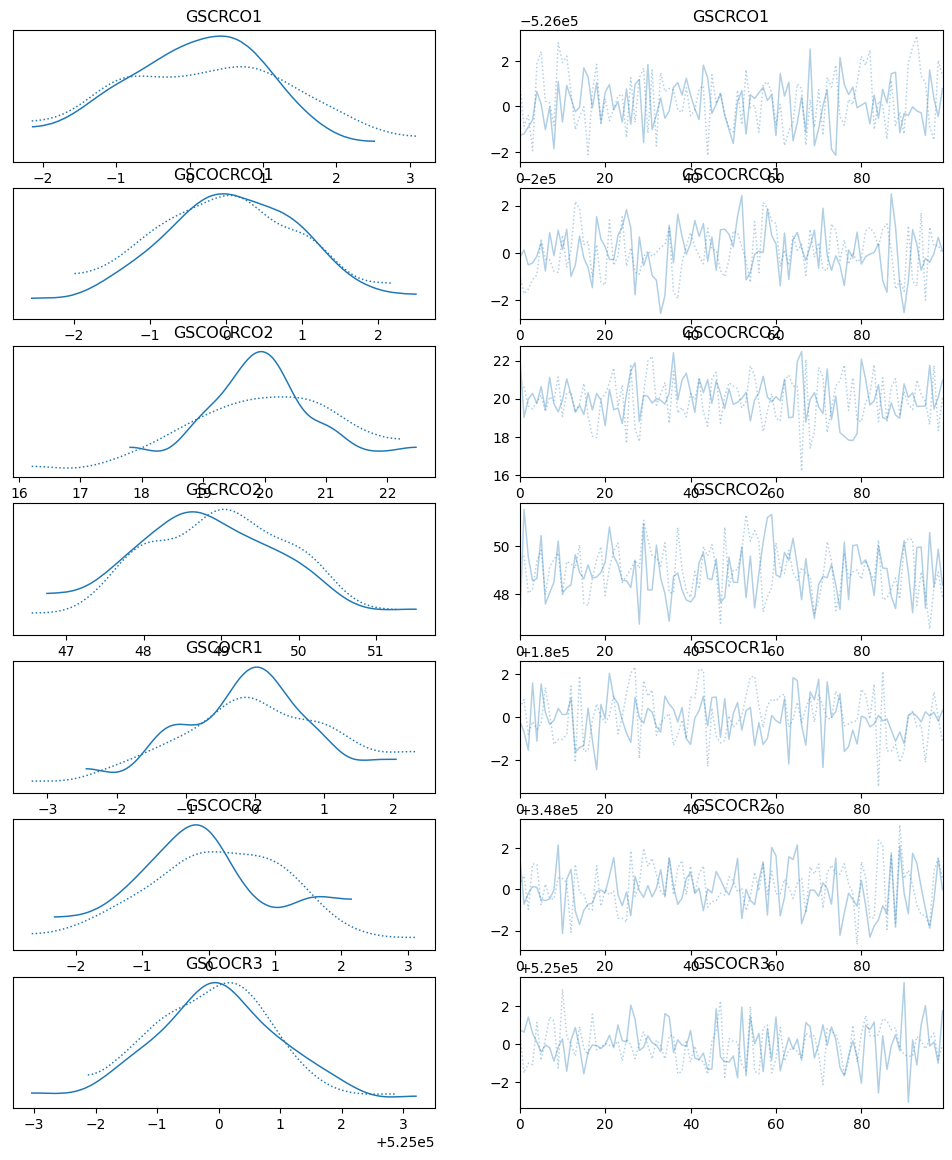

In [7]:
az.plot_trace(trace)

In [ ]:
trace.to_json('trace_cocr_500x1500_18.json')

# trace = az.from_json('trace_cocr_500x2000_18.json')
trace

Inference data with groups:
	> posterior
	> sample_stats

In [12]:
logl_2.y_eqs

[array([0.54019166, 0.54156228, 0.54764889, 0.55428139, 0.56099002,
        0.56723704]),
 array([0.54019166, 0.54156228, 0.54764889, 0.55428139, 0.56099002,
        0.56723704]),
 array([0.54019166, 0.54156228, 0.54764889, 0.55428139, 0.56099002,
        0.56723704]),
 array([0.54019166, 0.54156228, 0.54764889, 0.55428139, 0.56099002,
        0.56723704])]

In [13]:
logl_2.likelihoods

[array(-0.00084521),
 array(-0.00084521),
 array(-0.00084521),
 array(-0.00084521)]

In [14]:
likelihood_2.eval()

array(-0.00093353)

print(pytensor.config)

In [9]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [15]:
# не работает
# with test_model_2: 
#     pm.compute_log_likelihood(trace)

# 3 Вычисление предсказаний по трейсам

In [8]:
def from_trace_to_samples(trace, parameters_list):

    chains_num = trace.sample_stats.chain.data.shape
    draws_num = trace.sample_stats.draw.data.shape
    num_samples = chains_num[0]*draws_num[0]
    # print(num_samples)

    extract_trace = az.extract_dataset(trace, num_samples=num_samples)
    # print(extract_trace)

    parameters_dict = dict()

    for par in parameters_list:
        data = extract_trace.variables[par].data
        parameters_dict[par] = data
    
    return num_samples, parameters_dict
    



In [9]:
num, parameters_dict = from_trace_to_samples(trace, parameters_list)

In [14]:
# from datetime import datetime
start = datetime.now()
# print(datetime.now())
y_eq_trace = []
# t_eq_trace = []
temp_dict = dict()

for i in range(num):
    for par in parameters_list:
        val = parameters_dict[par][i] # i - номер вектора параметров из parameters_dict
        temp_dict[par] = val

        eq_temp = equilibrium(db10, elements, phases10, conditions, parameters = temp_dict)

        temp = from_xarray_to_pandas(eq_temp, phase)
        y_temp = temp['cr_conc'].to_numpy() 
        # t_temp = temp['T'].to_numpy()
        
        y_eq_trace.append(y_temp) # i - номер списка для i вектора параметров
        # t_eq_trace.append(t_temp) # i - номер списка для i вектора параметров и i списка в y, индекс каждого элемента внутри i списка соотв. индексу каждого элемента внутри i списка y_eq_trace
    
end = datetime.now()
print('time', end-start)

In [40]:
np.save('cac18_y_eq_trace.npy', y_eq_trace)

In [15]:
yt_dict = dict()

for i in range(len(T)):
    i_list = []
    
    for j in range(num):
        i_list.append(y_eq_trace[j][i])

    yt_dict[i] = i_list # key = индекс температуры в T

C:\Users\emgebrishvili\AppData\Local\Temp\ipykernel_12100\1729450169.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(yt_dict[i])
C:\Users\emgebrishvili\AppData\Local\Temp\ipykernel_12100\1729450169.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(yt_dict[i])
C:\Users

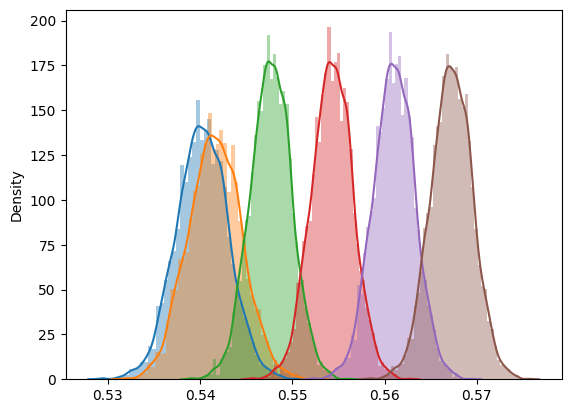

In [16]:
for i in range(len(T)):
    sns_plot = sns.distplot(yt_dict[i])
    fig = sns_plot.get_figure()

# 4 Построение диаграммы с результатами предсказаний

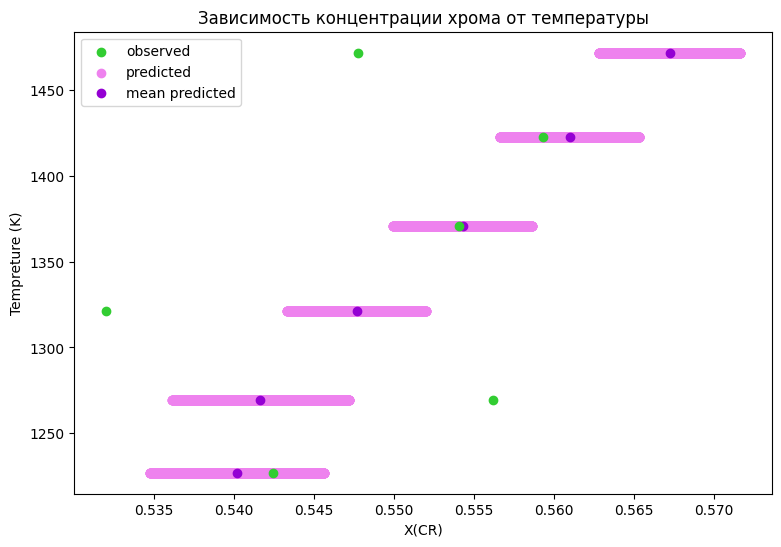

In [39]:
# Создаем фигуру и оси
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

axes.set_title('Зависимость концентрации хрома от температуры')


# Добавляем точки на график и задаем метки для легенды

for i in range(len(T)):
    min = np.percentile(yt_dict[i], 2.5)
    max = np.percentile(yt_dict[i], 100-2.5)
    mean = sum(yt_dict[i])/len(yt_dict[i])
    
    yt = [x for x in yt_dict[i] if x > min and x < max]
    
    scatter2 = axes.scatter(yt, np.repeat(T[i], len(yt)), label='predicted', color = 'violet')
    scatter3 = axes.scatter(mean, T[i], label='mean predicted', color = 'darkviolet')


scatter1 = axes.scatter(y_obs, T, label='observed', color = 'limegreen')

# Добавляем легенду на график
axes.legend(handles=[scatter1, scatter2, scatter3])

# Задаем название осей
axes.set_xlabel('X(CR)')
axes.set_ylabel('Tempreture (K)')

# Отображаем график
plt.show()